In [19]:
#Import necessary Packages
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
args={'input':r"F:\OCR\multi_column.png",
     'min_conf':0,
      'min_dist':25.0,
       'min_size':2}

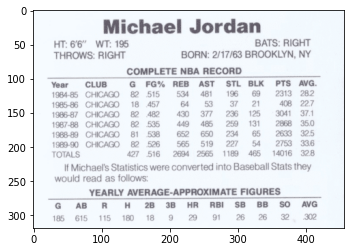

In [3]:
#Input Image
img=cv2.imread(args['input'])
plt.imshow(img)

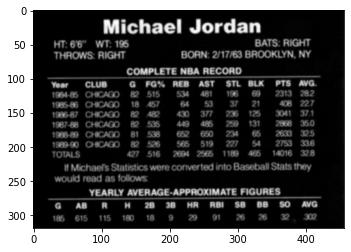

In [4]:
#Performing Morphological Operations blackhat
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
Kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(51,11))
gray=cv2.GaussianBlur(gray,(3,3),0)
blackhat=cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,Kernel)
plt.imshow(blackhat,cmap='gray')

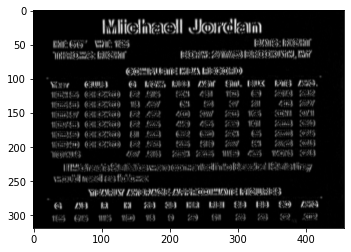

In [5]:
#Computing the gradients
grad=cv2.Sobel(blackhat,ddepth=cv2.CV_32F,dx=1,dy=0,ksize=-1)
grad=np.absolute(grad)
(minVal,maxVal)=(np.min(grad),np.max(grad))
grad=(grad-minVal)/(maxVal-minVal)
grad=(255*grad).astype('uint8')
plt.imshow(grad,cmap='gray')

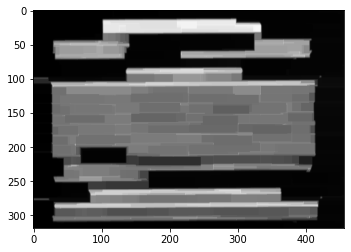

In [6]:
grad=cv2.morphologyEx(grad,cv2.MORPH_CLOSE,Kernel)
plt.imshow(grad,cmap='gray')

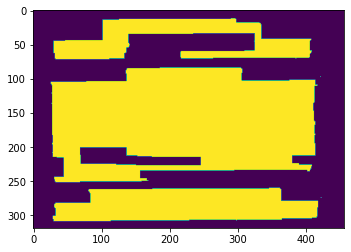

In [7]:
thresh=cv2.threshold(grad,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

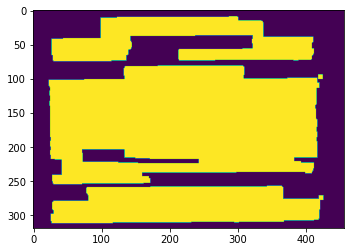

In [8]:
thresh=cv2.dilate(thresh,None,iterations=3)
plt.imshow(thresh)

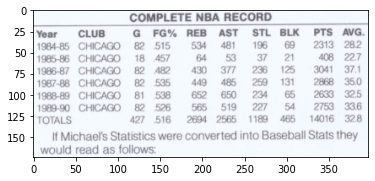

In [9]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)
tableCnt=max(cnts,key=cv2.contourArea)

(x,y,w,h)=cv2.boundingRect(tableCnt)
table=img[y:y+h,x:x+w]
plt.imshow(table)

In [10]:
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd=r'C:\Program Files\Tesseract-OCR\tesseract.exe'
options='--psm 6'

results=pytesseract.image_to_data(cv2.cvtColor(table,cv2.COLOR_BGR2RGB),
                                  config=options,output_type=Output.DICT)

In [11]:
results

{'level': [1,
  2,
  3,
  4,
  5,
  5,
  5,
  3,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  3,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  4,
  5,
  5,
  5,
  5],
 'page_num': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1

In [12]:
results.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [13]:
# initialize a list to store the (x, y)-coordinates of the detected
# text along with the OCR'd text itself

coords=[]
ocrText=[]

for i in range(0,len(results['text'])):
    x=results['left'][i]
    y=results['top'][i]
    w=results['width'][i]
    h=results['height'][i]
    
    text=results['text'][i]
    conf=int(results['conf'][i])
    
    if conf>args['min_conf']:
        coords.append((x,y,w,h))
        ocrText.append(text)

In [14]:
from sklearn.cluster import AgglomerativeClustering
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords=[(c[0],0) for c in coords]

# apply hierarchical agglomerative clustering to the coordinates
clustering=AgglomerativeClustering(n_clusters=None,affinity='manhattan',linkage='complete',
                                            distance_threshold=args['min_dist'])
clustering.fit(xCoords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=25.0,
                        linkage='complete', n_clusters=None)

In [15]:
sortedCluster=[]

# loop over all clusters
for l in np.unique(clustering.labels_):
    idx=np.where(clustering.labels_==l)[0]
    
    # verify that the cluster is sufficiently large
    if len(idx)>args['min_size']:
        avg=np.average([coords[i][0] for i in idx])
        sortedCluster.append((l,avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedCluster.sort(key=lambda x:x[1])
df=pd.DataFrame()

In [17]:
for (i,_) in sortedCluster:
    idx=np.where(clustering.labels_==i)[0]
    
    

    # extract the y-coordinates from the elements in the current
    # cluster, then sort them from top-to-bottom
    yCoords=[coords[i][1] for i in idx]
    sortedidx=idx[np.argsort(yCoords)]
    
    
    # generate a random color for the cluster
    color=np.random.randint(0,255,size=(3,),dtype='int')
    color=[int(c) for c in color]
    
    for i in sortedidx:
        (x,y,w,h)=coords[i]
        cv2.rectangle(table,(x,y),(x+w,y+h),color,2)
        
    # extract the OCR'd text for the current column, then construct
    # a data frame for the data where the first entry in our column
    # serves as the header
    cols=[ocrText[i].strip() for i in sortedidx]
    currentDF=pd.DataFrame({cols[0]:cols[1:]})
    
    df=pd.concat([df,currentDF],axis=1)

In [18]:
from tabulate import tabulate
df.fillna("",inplace=True)
print(tabulate(df,headers='keys',tablefmt='psql'))

+----+---------+-----------+------------+-------+-----------+----------+-------+-------+-----------+--------+
|    | Year    | CHICAGO   | COMPLETE   | FG%   | NBA       | RECORD   | STL   | BLK   | PTS       | AVG.   |
|----+---------+-----------+------------+-------+-----------+----------+-------+-------+-----------+--------|
|  0 | 1964-85 | CHICAGO   | 82         | 515   | REB       | AST      | 19%   | 69    | 2313      | 282    |
|  1 | 1985-86 | CHICAGO   | 18         | 457   | 5M        | 481      | 296   | 21    | 408       | 227    |
|  2 | 1986-87 | CHICAGO   | 82         | 482   | 64        | 53°      | 259   | 125   | 3041      | 37.1   |
|  3 | 1987-88 | CHICAGO   | 82         | 535   | 430       | 377      | 234   | 131   | 2868      | 350    |
|  4 | 1988-89 | CHICAGO   | 81         | 538   | 449       | 485      | 227   | 65    | «2633-925 | 336    |
|  5 | 1969-90 | read      | 8          | 526   | 652       | 650      | 1189  | 54    | 2753      | 328    |
|  6 | TOT